# Deep learning for computer vision


This notebook will teach you to build and train convolutional networks for image recognition. Brace yourselves.

# CIFAR dataset
This week, we shall focus on the image recognition problem on cifar10 dataset
* 60k images of shape 3x32x32
* 10 different classes: planes, dogs, cats, trucks, etc.

<img src="https://github.com/yandexdataschool/Practical_DL/blob/fall23/week03_convnets/cifar10.jpg?raw=1" style="width:80%">

In [1]:
# when running in colab, un-comment this
# !wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall19/week03_convnets/cifar.py

In [2]:
import numpy as np
from cifar import load_cifar10
X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10("cifar_data")

class_names = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer',
                        'dog', 'frog', 'horse', 'ship', 'truck'])

print(X_train.shape,y_train.shape)

(40000, 3, 32, 32) (40000,)


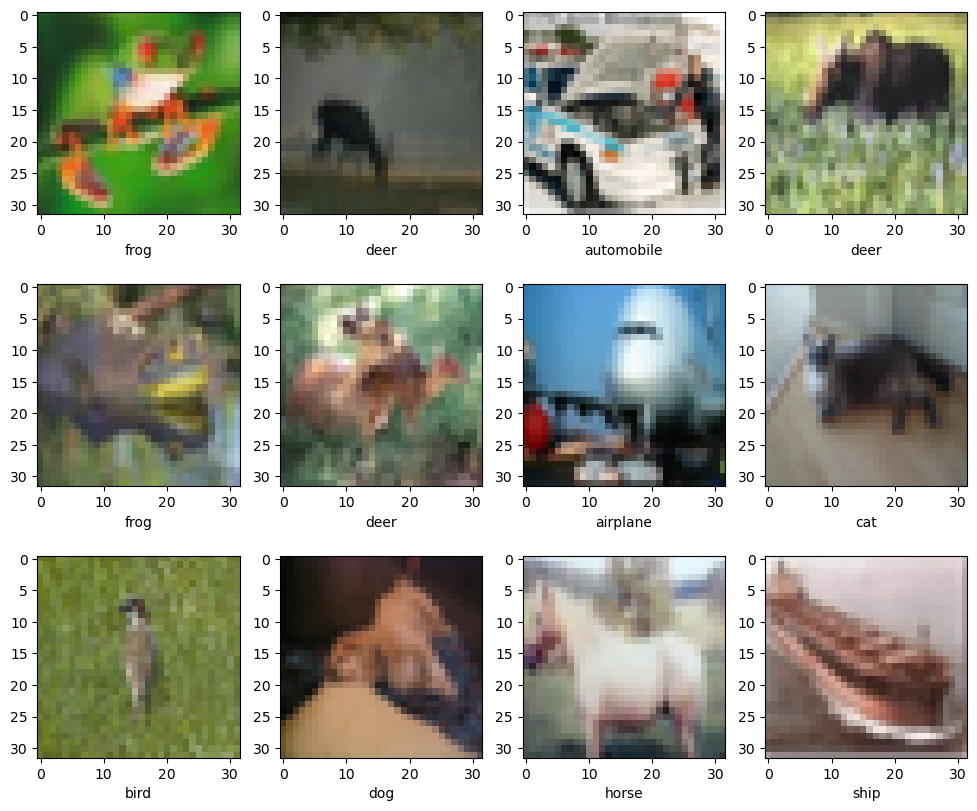

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[12,10])
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.xlabel(class_names[y_train[i]])
    plt.imshow(np.transpose(X_train[i],[1,2,0]))

# Building a network

Simple neural networks with layers applied on top of one another can be implemented as `torch.nn.Sequential` - just add a list of pre-built modules and let it train.

In [4]:
import torch, torch.nn as nn
import torch.nn.functional as F

# a special module that converts [batch, channel, w, h] to [batch, units]
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

Let's start with a dense network for our baseline:

In [5]:
model = nn.Sequential()

# reshape from "images" to flat vectors
model.add_module('flatten', Flatten())

# dense "head"
model.add_module('dense1', nn.Linear(3 * 32 * 32, 32*24))
model.add_module('dense1_relu', nn.ReLU())
#model.add_module('dense15', nn.Linear(32*8*4, 32*8))
#model.add_module('dense15_relu', nn.ReLU())
model.add_module('dense2', nn.Linear(32*24, 32*6))
model.add_module('dense2_relu', nn.ReLU())
model.add_module('dense3', nn.Linear(32*6, 64))
model.add_module('dense3_relu', nn.ReLU())
model.add_module('dense3_logits', nn.Linear(64, 10)) # logits for 10 classes

As in our basic tutorial, we train our model with negative log-likelihood aka crossentropy.

In [6]:
def compute_loss(X_batch, y_batch):
    X_batch = torch.as_tensor(X_batch, dtype=torch.float32)
    y_batch = torch.as_tensor(y_batch, dtype=torch.int64)
    logits = model(X_batch)
    return F.cross_entropy(logits, y_batch).mean()

In [7]:
# example
compute_loss(X_train[:5], y_train[:5])

tensor(2.2547, grad_fn=<MeanBackward0>)

### Training on minibatches
* We got 40k images, that's way too many for a full-batch SGD. Let's train on minibatches instead
* Below is a function that splits the training sample into minibatches

In [8]:
# An auxilary function that returns mini-batches for neural network training
def iterate_minibatches(X, y, batchsize):
    indices = np.random.permutation(np.arange(len(X)))
    for start in range(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield X[ix], y[ix]

In [9]:
model.dense2.weight.grad

In [19]:
len(list_of_grads)

625

In [20]:
import pickle
with open("list_of_grads1", "wb") as fp:   #Pickling
    pickle.dump(list_of_grads, fp)

In [11]:
opt = torch.optim.SGD(model.parameters(), lr=0.01)

train_loss = []
val_accuracy = []

In [12]:
len(X_train)

40000

In [51]:
model.load_state_dict(torch.load("./state_dict.pth"))

/tmp/ipykernel_852917/2192108387.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./state_dict.pth"))


<All keys matched successfully>

In [17]:
len(list_of_grads)

422

In [18]:
import time
num_epochs = 1 # total amount of full passes over training data
batch_size = 64  # number of samples processed in one SGD iteration

list_of_grads = []

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size):
        # train on batch
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        list_of_grads.append(model.dense2.weight.grad)
        opt.zero_grad()
        train_loss.append(loss.data.numpy())

    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size):
        logits = model(torch.as_tensor(X_batch, dtype=torch.float32))
        y_pred = logits.max(1)[1].data.numpy()
        val_accuracy.append(np.mean(y_batch == y_pred))


    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(
        np.mean(train_loss[-len(X_train) // batch_size :])))
    print("  validation accuracy: \t\t\t{:.2f} %".format(
        np.mean(val_accuracy[-len(X_val) // batch_size :]) * 100))

Epoch 1 of 1 took 44.485s
  training loss (in-iteration): 	1.186886
  validation accuracy: 			53.71 %


Don't wait for full 100 epochs. You can interrupt training after 5-20 epochs once validation accuracy stops going up.
```

```

```

```

```

```

```

```

```

```

### Final test

In [52]:
model.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in iterate_minibatches(X_test, y_test, 500):
    logits = model(torch.as_tensor(X_batch, dtype=torch.float32))
    y_pred = logits.max(1)[1].data.numpy()
    test_batch_acc.append(np.mean(y_batch == y_pred))

test_accuracy = np.mean(test_batch_acc)

print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))



Final results:
  test accuracy:		52.20 %


## Regular svd

In [59]:
def factorize_to_svd(fc_w, fc_b, rank):
    U, S, Vt = np.linalg.svd(fc_w, full_matrices=False)
    # truncate SVD and fuse Sigma matrix
    w1 = np.dot(np.diag(np.sqrt(S[0:rank])),Vt[0:rank, :])
    w2 = np.dot(U[:,0:rank,], np.diag(np.sqrt(S[0:rank])))

    # create new layers and insert weights
    out_features, in_features = fc_w.shape
    is_bias = fc_b is not None

    linear1 = nn.Linear(in_features = in_features,
                      out_features = rank,
                      bias = False)
    linear1.weight = nn.Parameter(torch.FloatTensor(w1))

    linear2 = nn.Linear(in_features = rank,
                      out_features = out_features,
                      bias=is_bias)
    linear2.weight = nn.Parameter(torch.FloatTensor(w2))
    linear2.bias = nn.Parameter(torch.FloatTensor(fc_b))
    print (w1.shape, w2.shape)
    # create factorized layer
    factorized_layer = nn.Sequential(linear1,linear2)
    return factorized_layer

In [60]:
model.dense2 

Linear(in_features=768, out_features=192, bias=True)

In [61]:
fc_w = model.dense2.weight.data.cpu().data.numpy()
fc_b = model.dense2.bias.data.cpu().data.numpy()

In [62]:
linear2 = nn.Linear(in_features = 768, out_features = 192, bias=True)
linear2.weight = nn.Parameter(torch.FloatTensor(fc_w ))
linear2.bias = nn.Parameter(torch.FloatTensor(fc_b))

In [78]:
model.dense2 = factorize_to_svd(fc_w, fc_b, 10)

(10, 768) (192, 10)


In [79]:
model.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in iterate_minibatches(X_test, y_test, 500):
    logits = model(torch.as_tensor(X_batch, dtype=torch.float32))
    y_pred = logits.max(1)[1].data.numpy()
    test_batch_acc.append(np.mean(y_batch == y_pred))

test_accuracy = np.mean(test_batch_acc)

print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

Final results:
  test accuracy:		50.57 %


In [205]:
!pwd

/home/jovyan/shares/SR004.nfs2/chekalina/FisherKronecker/small_nn


In [206]:
torch.save(model.state_dict(), "/home/jovyan/shares/SR004.nfs2/chekalina/FisherKronecker/small_nn/state_dict.pth")

## SVD with factors

In [19]:
#B1 = np.load("Bnew_square.npy")
#C1 = np.load("Bnew_square.npy")

In [80]:
B1_square = np.load("Bnew_square.npy")#np.linalg.cholesky(B1)
C1_square = np.load("Cnew_square.npy")#np.linalg.cholesky(C1)

In [81]:
B1_square.shape

(192, 192)

In [82]:
C1_square.shape

(768, 768)

In [83]:
fc_w.shape

(192, 768)

In [29]:
Vt.shape

NameError: name 'Vt' is not defined

In [ ]:
# initial 
# U, S, Vt = np.linalg.svd(fc_w, full_matrices=False)
# w1 = np.dot(np.diag(np.sqrt(S[0:rank])),Vt[0:rank, :])
# w2 = np.dot(U[:,0:rank,], np.diag(np.sqrt(S[0:rank])))

In [173]:
V1t.shape

(192, 768)

In [84]:
U, S, Vt = np.linalg.svd(B1_square.T@fc_w@C1_square, full_matrices=False)

U1 = np.linalg.inv(B1_square.T)@U
V1 = np.linalg.inv(C1_square.T)@Vt.T

print((U1.T@B1_square@U1)[:3,:3])
print((V1.T@C1_square@V1)[:3,:3])

[[ 1.41368476 -0.01229791 -0.00618887]
 [ 0.00878873  1.39786773 -0.01803011]
 [-0.00287225  0.01130177  1.38975854]]
[[ 1.89063753e+00 -5.93129348e-04  4.92302741e-03]
 [ 6.66119604e-04  1.89194462e+00 -9.74382565e-04]
 [-3.59082086e-03  2.50745538e-03  1.89031742e+00]]


In [68]:
U1.shape

(192, 192)

In [69]:
V1.shape

(768, 192)

In [70]:
rank =3
V1.T[:rank, :].shape

(3, 768)

In [71]:
U1[:,0:rank].shape

(192, 3)

In [72]:
rank =10
w1 = np.diag(np.sqrt(S[:rank]))@V1.T[:rank, :]
w2 = U1[:,0:rank] @ np.diag(np.sqrt(S[:rank]))

In [73]:
w1.shape

(10, 768)

In [74]:
w2.shape

(192, 10)

In [75]:
out_features, in_features = fc_w.shape
is_bias = fc_b is not None

linear1 = nn.Linear(in_features = in_features,
                      out_features = rank,
                      bias = False)
linear1.weight = nn.Parameter(torch.FloatTensor(w1))

linear2 = nn.Linear(in_features = rank,
                      out_features = out_features,
                      bias=is_bias)
linear2.weight = nn.Parameter(torch.FloatTensor(w2))
linear2.bias = nn.Parameter(torch.FloatTensor(fc_b))

# create factorized layer
factorized_layer = nn.Sequential(linear1,linear2)

In [76]:
model.dense2 = factorized_layer

In [77]:
model.train(False) # disable dropout / use averages for batch_norm
test_batch_acc = []
for X_batch, y_batch in iterate_minibatches(X_test, y_test, 500):
    logits = model(torch.as_tensor(X_batch, dtype=torch.float32))
    y_pred = logits.max(1)[1].data.numpy()
    test_batch_acc.append(np.mean(y_batch == y_pred))

test_accuracy = np.mean(test_batch_acc)

print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_accuracy * 100))

Final results:
  test accuracy:		49.73 %
